In [1]:
# True: Google Colab Notebook
# False: My local PC
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !ls /content/drive/MyDrive/output/otto/
    base_path = '/content/drive/MyDrive'
else:
    base_path = '../data'

# Preprocessing

In [2]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

In [3]:
#test = pd.read_parquet('/content/drive/MyDrive/output/otto/test.parquet')
test = pd.read_parquet(f'{base_path}/output/otto/test_50_tmp.parquet')

In [4]:
# fileを分割して書き出す, 0 or 1
OUTPUT_SPLIT_NUM = 1

output_session_splits = 2
min_val = test['session'].min()
max_val = test['session'].max()
print('OUTPUT_SPLIT_NUM=', OUTPUT_SPLIT_NUM)
print('original min session:', min_val, 'max_session:', max_val, 'shape:', test.shape)

output_session_splits_list = [int(min_val) + int(i*(max_val - min_val) / output_session_splits) for i in range(output_session_splits)]
print('output_session_splits=', output_session_splits)
print('output_session_splits_list=', output_session_splits_list)

if OUTPUT_SPLIT_NUM == output_session_splits - 1:
    test = test[output_session_splits_list[OUTPUT_SPLIT_NUM] <= test['session']]
else:
    test = test[(output_session_splits_list[OUTPUT_SPLIT_NUM] <= test['session']) & (test['session'] < output_session_splits_list[OUTPUT_SPLIT_NUM + 1])]
print('after min session:', test['session'].min(), 'max_session:', test['session'].max(), 'shape:', test.shape)

OUTPUT_SPLIT_NUM= 1
original min session: 12899779 max_session: 14571581 shape: (143574745, 23)
output_session_splits= 2
output_session_splits_list= [12899779, 13735680]
after min session: 13735680 max_session: 14571581 shape: (71794968, 23)


In [5]:
DEBUG_MODE = False
#DEBUG_MODE = True

if DEBUG_MODE:
    test = test.head(100000)
IGNORE_COL = ['session','aid']

type_list = ['clicks', 'carts', 'orders']
#type_list = ['carts', 'orders']
#type_list = ['orders']


#TYPE_MODE = 'clicks'
#TYPE_MODE = 'carts'
#TYPE_MODE = 'orders'

In [6]:
def reduce_memory(df):
    df['session'] = df['session'].astype('int32')
    df['aid'] = df['aid'].astype('int32')
    df['score_click'] = df['score_click'].astype('float32')
    df['score_cart'] = df['score_cart'].astype('float32')
    df['score_buy'] = df['score_buy'].astype('float32')
    df['score_click_only'] = df['score_click_only'].astype('float32')
    df['score_cart_only'] = df['score_cart_only'].astype('float32')
    df['score_buy_only'] = df['score_buy_only'].astype('float32')
    df['session_action_count'] = df['session_action_count'].astype('int16')
    df['session_click_count'] = df['session_click_count'].astype('int16')
    df['session_cart_count'] = df['session_cart_count'].astype('int16')
    df['session_order_count'] = df['session_order_count'].astype('int16')
    df['session_type_mean'] = df['session_type_mean'].astype('float32')
    
    click_topn_list = [10, 20]
    for i in click_topn_list:
        df[f'n_clicks_{i}'] = df[f'n_clicks_{i}'].astype('int8')

    df['n_carts'] = df['n_carts'].astype('int8')
    df['n_buys'] = df['n_buys'].astype('int8')
    df['clicks_count'] = df['clicks_count'].astype('int32')
    df['carts_count'] = df['carts_count'].astype('int16')
    df['orders_count'] = df['orders_count'].astype('int16')
    return df

In [7]:
def join_session_features(df):
    
    session_df = pd.read_parquet(f'{base_path}/output/otto/test_session_features.parquet')
    session_df['session'] = session_df['session'].astype('int32')
    session_df['session_action_count'] = session_df['session_action_count'].astype('int16')
    session_df['session_click_count'] = session_df['session_click_count'].astype('int16')
    session_df['session_cart_count'] = session_df['session_cart_count'].astype('int16')
    session_df['session_order_count'] = session_df['session_order_count'].astype('int16')
    session_df['session_type_mean'] = session_df['session_type_mean'].astype('float32')
    session_df['session_click_rate'] = session_df['session_click_rate'].astype('float32')
    session_df['session_cart_rate'] = session_df['session_cart_rate'].astype('float32')
    session_df['session_order_rate'] = session_df['session_order_rate'].astype('float32')

    session_df['session_last_type'] = session_df['session_last_type'].astype('int8')
    session_df['session_first_action_ts_diff'] = session_df['session_first_action_ts_diff'].astype('int32')
    session_df['session_last_action_ts_diff'] = session_df['session_last_action_ts_diff'].astype('int32')
    session_df['session_ts_period'] = session_df['session_ts_period'].astype('int32')
    session_df['session_mean_action_ts_diff'] = session_df['session_mean_action_ts_diff'].astype('float32')
    session_df['session_unique_aid_action_count'] = session_df['session_unique_aid_action_count'].astype('int16')
    session_df['session_unique_aid_click_count'] = session_df['session_unique_aid_click_count'].astype('int16')
    session_df['session_unique_aid_cart_count'] = session_df['session_unique_aid_cart_count'].astype('int16')
    session_df['session_unique_aid_order_count'] = session_df['session_unique_aid_order_count'].astype('int16')
    session_df['session_click_rate'] = session_df['session_click_rate'].astype('float32')
    session_df['session_cart_rate'] = session_df['session_cart_rate'].astype('float32')
    session_df['session_order_rate'] = session_df['session_order_rate'].astype('float32') 
    session_df['session_unique_aid_click_rate'] = session_df['session_unique_aid_click_rate'].astype('float32')
    session_df['session_unique_aid_cart_rate'] = session_df['session_unique_aid_cart_rate'].astype('float32')
    session_df['session_unique_aid_order_rate'] = session_df['session_unique_aid_order_rate'].astype('float32')
    session_df['session_total_uu_action_ratio'] = session_df['session_total_uu_action_ratio'].astype('float32')
    session_df['session_clicks_uu_action_ratio'] = session_df['session_clicks_uu_action_ratio'].astype('float32')
    session_df['session_carts_uu_action_ratio'] = session_df['session_carts_uu_action_ratio'].astype('float32')
    session_df['session_orders_uu_action_ratio'] = session_df['session_orders_uu_action_ratio'].astype('float32')

    week_list = ['4weeks', '2weeks', '1week']
    for i in week_list:
        lis = [f'aid_clicks_count_{i}', 
              f'aid_carts_count_{i}', 
              f'aid_orders_count_{i}', 
              f'aid_total_count_{i}', 
              f'aid_total_uu_{i}', 
              f'aid_clicks_uu_{i}', 
              f'aid_carts_uu_{i}', 
              f'aid_orders_uu_{i}',
              f'aid_total_uu_action_ratio_{i}',
              f'aid_clicks_uu_action_ratio_{i}',
              f'aid_carts_uu_action_ratio_{i}',
              f'aid_orders_uu_action_ratio_{i}']
    for l in lis:
        session_df[f'session_mean_{l}'] = session_df[f'session_mean_{l}'].astype('float32')

    remove_col = ['session_action_count', 'session_click_count', 'session_cart_count', 'session_order_count', 'session_type_mean']
    df = df.drop(remove_col , axis=1)
    df = df.merge(session_df, 'left', 'session')
    del session_df
    gc.collect()
    
    return df

In [8]:
def join_aid_features(df):
    aid_df = pd.read_parquet(f'{base_path}/output/otto/test_aid_features.parquet')
    #week_list = ['4weeks', '3weeks', '2weeks', '1week']
    week_list = ['4weeks', '2weeks', '1week']
    aid_df['aid'] = aid_df['aid'].astype('int32')
    for i in week_list:
        aid_df[f'aid_total_count_{i}'] = aid_df[f'aid_total_count_{i}'].astype('int32')
        aid_df[f'aid_clicks_count_{i}'] = aid_df[f'aid_clicks_count_{i}'].astype('int32')
        aid_df[f'aid_carts_count_{i}'] = aid_df[f'aid_carts_count_{i}'].astype('int16')
        aid_df[f'aid_orders_count_{i}'] = aid_df[f'aid_orders_count_{i}'].astype('int16')
        aid_df[f'aid_clicks_rank_{i}'] = aid_df[f'aid_clicks_rank_{i}'].astype('int32')
        aid_df[f'aid_carts_rank_{i}'] = aid_df[f'aid_carts_rank_{i}'].astype('int32')
        aid_df[f'aid_orders_rank_{i}'] = aid_df[f'aid_orders_rank_{i}'].astype('int32')

        aid_df[f'aid_total_uu_{i}'] = aid_df[f'aid_total_uu_{i}'].astype('int32')
        aid_df[f'aid_clicks_uu_{i}'] = aid_df[f'aid_clicks_uu_{i}'].astype('int32')
        aid_df[f'aid_carts_uu_{i}'] = aid_df[f'aid_carts_uu_{i}'].astype('int32')
        aid_df[f'aid_orders_uu_{i}'] = aid_df[f'aid_orders_uu_{i}'].astype('int32')
        aid_df[f'aid_total_uu_action_ratio_{i}']  = aid_df[f'aid_total_uu_action_ratio_{i}'].astype('float32')  
        aid_df[f'aid_clicks_uu_action_ratio_{i}'] = aid_df[f'aid_clicks_uu_action_ratio_{i}'].astype('float32') 
        aid_df[f'aid_carts_uu_action_ratio_{i}']  = aid_df[f'aid_carts_uu_action_ratio_{i}'].astype('float32')
        aid_df[f'aid_orders_uu_action_ratio_{i}'] = aid_df[f'aid_orders_uu_action_ratio_{i}'].astype('float32')
        aid_df[f'aid_mean_session_action_count_{i}'] = aid_df[f'aid_mean_session_action_count_{i}'].astype('float32') 
        aid_df[f'aid_mean_session_click_count_{i}']  = aid_df[f'aid_mean_session_click_count_{i}'].astype('float32')  
        aid_df[f'aid_mean_session_cart_count_{i}']   = aid_df[f'aid_mean_session_cart_count_{i}'].astype('float32')   
        aid_df[f'aid_mean_session_order_count_{i}']  = aid_df[f'aid_mean_session_order_count_{i}'].astype('float32')  
        aid_df[f'aid_mean_session_type_mean_{i}']    = aid_df[f'aid_mean_session_type_mean_{i}'].astype('float32') 

    for j in ['clicks', 'carts', 'orders']:
        #for k in [2,3,4]:
        for k in [2,4]:
            aid_df[f'aid_{j}_count_rate_1_{k}'] = aid_df[f'aid_{j}_count_rate_1_{k}'].astype('float32')
            aid_df[f'aid_{j}_uu_rate_1_{k}'] = aid_df[f'aid_{j}_uu_rate_1_{k}'].astype('float32')
        # i loopの一回だけ実行
        if i == 'clicks':
            aid_df[f'aid_total_uu_rate_1_{k}'] = aid_df[f'aid_total_uu_rate_1_{k}'].astype('float32')

    remove_col = ['clicks_rank', 'carts_rank', 'orders_rank', 'clicks_count', 'carts_count', 'orders_count']
    df = df.drop(remove_col , axis=1)
    df = df.merge(aid_df, 'left', 'aid')
    del aid_df
    gc.collect()
    
    return df

In [9]:
def join_interactive_features(df):
    # session単位でのmean aid feature v.s. aid feature
    #week_list = ['4weeks', '2weeks', '1week']
    week_list = ['4weeks']

    for i in week_list:
        # ratio feature
        lis1 = [f'aid_clicks_count_{i}', 
                f'aid_carts_count_{i}', 
                f'aid_orders_count_{i}', 
                f'aid_total_count_{i}', 
                f'aid_total_uu_{i}', 
                f'aid_clicks_uu_{i}', 
                f'aid_carts_uu_{i}', 
                f'aid_orders_uu_{i}',]
        for l1 in lis1:
            df[f'i_ratio_{l1}'] = df[f'session_mean_{l1}'] / (df[l1] +  + 0.000001)
            df[f'i_ratio_{l1}'] = df[f'i_ratio_{l1}'].astype('float32')

       # aid単位でのmean session feature v.s. session feature
        lis3 = ['session_action_count',
                'session_click_count',
                'session_cart_count',
                'session_order_count',]

        for l3 in lis3:
            df[f'i_ratio_{l3}_{i}'] = df[f'aid_mean_{l3}_{i}'] / (df[l3] +  + 0.000001)
            df[f'i_ratio_{l3}_{i}'] = df[f'i_ratio_{l3}_{i}'].astype('float32')
        df[f'i_diff_session_type_mean_{i}'] = df[f'aid_mean_session_type_mean_{i}'] - df['session_type_mean']
    return df

In [10]:
# importanceが極端に低いものを削る (18件)
def remove_features(df):
    '''
    DROP_COL = ['session_type_mean',
                #'i_ratio_session_order_count_1week',
                'aid_mean_session_order_count_1week',
                'session_unique_aid_order_count',
                #'i_diff_session_type_mean_1week',
                'aid_mean_session_click_count_1week',
                #'i_ratio_session_cart_count_1week',
                'aid_mean_session_action_count_1week',
                'aid_mean_session_cart_count_1week',
                'session_mean_aid_clicks_uu_2weeks',
                'aid_mean_session_type_mean_1week',
                'session_mean_aid_total_uu_2weeks',
                'aid_mean_session_order_count_2weeks',
                #'i_ratio_session_click_count_1week',
                'session_mean_aid_carts_uu_2weeks',
                'aid_mean_session_type_mean_2weeks',
                'session_mean_aid_orders_count_1week',
                #'i_ratio_aid_total_count_2weeks',
                ]
    '''
    DROP_COL = ['session_type_mean']
    '''
    DROP_COL2 = ['session_mean_aid_total_count_4weeks',
                 'i_ratio_session_order_count_2weeks',
                 'i_ratio_session_action_count_1week',
                 'session_mean_aid_clicks_uu_4weeks',
                 'i_diff_session_type_mean_4weeks',
                 'aid_orders_uu_rate_1_2',
                 'i_diff_session_type_mean_2weeks',
                 'session_mean_aid_carts_count_2weeks',
                 'session_mean_aid_carts_uu_4weeks',
                 'aid_orders_uu_rate_1_4',]
    '''
    df = df.drop(DROP_COL, axis=1)
    return df

In [11]:
test = reduce_memory(test)

In [12]:
test.shape

(71794968, 23)

In [13]:
# join aid and session features
test = join_session_features(test)
test = join_aid_features(test)

In [14]:
test = join_interactive_features(test)

In [15]:
test = remove_features(test)

In [16]:
test

,session,aid,score_click,score_cart,score_buy,score_click_only,score_cart_only,score_buy_only,n_clicks_10,n_clicks_20,n_carts,n_buys,session_action_count,session_click_count,session_cart_count,session_order_count,session_last_type,session_first_action_ts_diff,session_last_action_ts_diff,session_ts_period,session_mean_action_ts_diff,session_unique_aid_action_count,session_unique_aid_click_count,session_unique_aid_cart_count,session_unique_aid_order_count,session_click_rate,session_cart_rate,session_order_rate,session_unique_aid_click_rate,session_unique_aid_cart_rate,session_unique_aid_order_rate,session_total_uu_action_ratio,session_clicks_uu_action_ratio,session_carts_uu_action_ratio,session_orders_uu_action_ratio,session_mean_aid_clicks_count_4weeks,session_mean_aid_carts_count_4weeks,session_mean_aid_orders_count_4weeks,session_mean_aid_total_count_4weeks,session_mean_aid_total_uu_4weeks,session_mean_aid_clicks_uu_4weeks,session_mean_aid_carts_uu_4weeks,session_mean_aid_orders_uu_4weeks,session_mean_aid_total_uu_action_ratio_4weeks,session_mean_aid_clicks_uu_action_ratio_4weeks,session_mean_aid_carts_uu_action_ratio_4weeks,session_mean_aid_orders_uu_action_ratio_4weeks,session_mean_aid_clicks_count_2weeks,session_mean_aid_carts_count_2weeks,session_mean_aid_orders_count_2weeks,session_mean_aid_total_count_2weeks,session_mean_aid_total_uu_2weeks,session_mean_aid_clicks_uu_2weeks,session_mean_aid_carts_uu_2weeks,session_mean_aid_orders_uu_2weeks,session_mean_aid_total_uu_action_ratio_2weeks,session_mean_aid_clicks_uu_action_ratio_2weeks,session_mean_aid_carts_uu_action_ratio_2weeks,session_mean_aid_orders_uu_action_ratio_2weeks,session_mean_aid_clicks_count_1week,session_mean_aid_carts_count_1week,session_mean_aid_orders_count_1week,session_mean_aid_total_count_1week,session_mean_aid_total_uu_1week,session_mean_aid_clicks_uu_1week,session_mean_aid_carts_uu_1week,session_mean_aid_orders_uu_1week,session_mean_aid_total_uu_action_ratio_1week,session_mean_aid_clicks_uu_action_ratio_1week,session_mean_aid_carts_uu_action_ratio_1week,session_mean_aid_orders_uu_action_ratio_1week,aid_clicks_count_4weeks,aid_carts_count_4weeks,aid_orders_count_4weeks,aid_total_count_4weeks,aid_total_uu_4weeks,aid_clicks_uu_4weeks,aid_carts_uu_4weeks,aid_orders_uu_4weeks,aid_total_uu_action_ratio_4weeks,aid_clicks_uu_action_ratio_4weeks,aid_carts_uu_action_ratio_4weeks,aid_orders_uu_action_ratio_4weeks,aid_clicks_rank_4weeks,aid_carts_rank_4weeks,aid_orders_rank_4weeks,aid_mean_session_action_count_4weeks,aid_mean_session_click_count_4weeks,aid_mean_session_cart_count_4weeks,aid_mean_session_order_count_4weeks,aid_mean_session_type_mean_4weeks,aid_clicks_count_2weeks,aid_carts_count_2weeks,aid_orders_count_2weeks,aid_total_count_2weeks,aid_total_uu_2weeks,aid_clicks_uu_2weeks,aid_carts_uu_2weeks,aid_orders_uu_2weeks,aid_total_uu_action_ratio_2weeks,aid_clicks_uu_action_ratio_2weeks,aid_carts_uu_action_ratio_2weeks,aid_orders_uu_action_ratio_2weeks,aid_clicks_rank_2weeks,aid_carts_rank_2weeks,aid_orders_rank_2weeks,aid_mean_session_action_count_2weeks,aid_mean_session_click_count_2weeks,aid_mean_session_cart_count_2weeks,aid_mean_session_order_count_2weeks,aid_mean_session_type_mean_2weeks,aid_clicks_count_1week,aid_carts_count_1week,aid_orders_count_1week,aid_total_count_1week,aid_total_uu_1week,aid_clicks_uu_1week,aid_carts_uu_1week,aid_orders_uu_1week,aid_total_uu_action_ratio_1week,aid_clicks_uu_action_ratio_1week,aid_carts_uu_action_ratio_1week,aid_orders_uu_action_ratio_1week,aid_clicks_rank_1week,aid_carts_rank_1week,aid_orders_rank_1week,aid_mean_session_action_count_1week,aid_mean_session_click_count_1week,aid_mean_session_cart_count_1week,aid_mean_session_order_count_1week,aid_mean_session_type_mean_1week,aid_clicks_count_rate_1_2,aid_clicks_uu_rate_1_2,aid_total_uu_rate_1_2,aid_clicks_count_rate_1_4,aid_clicks_uu_rate_1_4,aid_total_uu_rate_1_4,aid_carts_count_rate_1_2,aid_carts_uu_rate_1_2,aid_carts_count_rate_1_4,aid_carts_uu_rate_1_4,aid_o

In [17]:
n_splits = 5
session_splits = 5

In [18]:
min_val = test['session'].min()
max_val = test['session'].max()
print('min session:', min_val, 'max_session:', max_val)

session_splits_list = [int(min_val) + int(i*(max_val - min_val) / session_splits) for i in range(session_splits)]
print('session_splits=', session_splits)
print('session_splits_list=', session_splits_list)

min session: 13735680 max_session: 14571581
session_splits= 5
session_splits_list= [13735680, 13902860, 14070040, 14237220, 14404400]


# Read Models

In [19]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

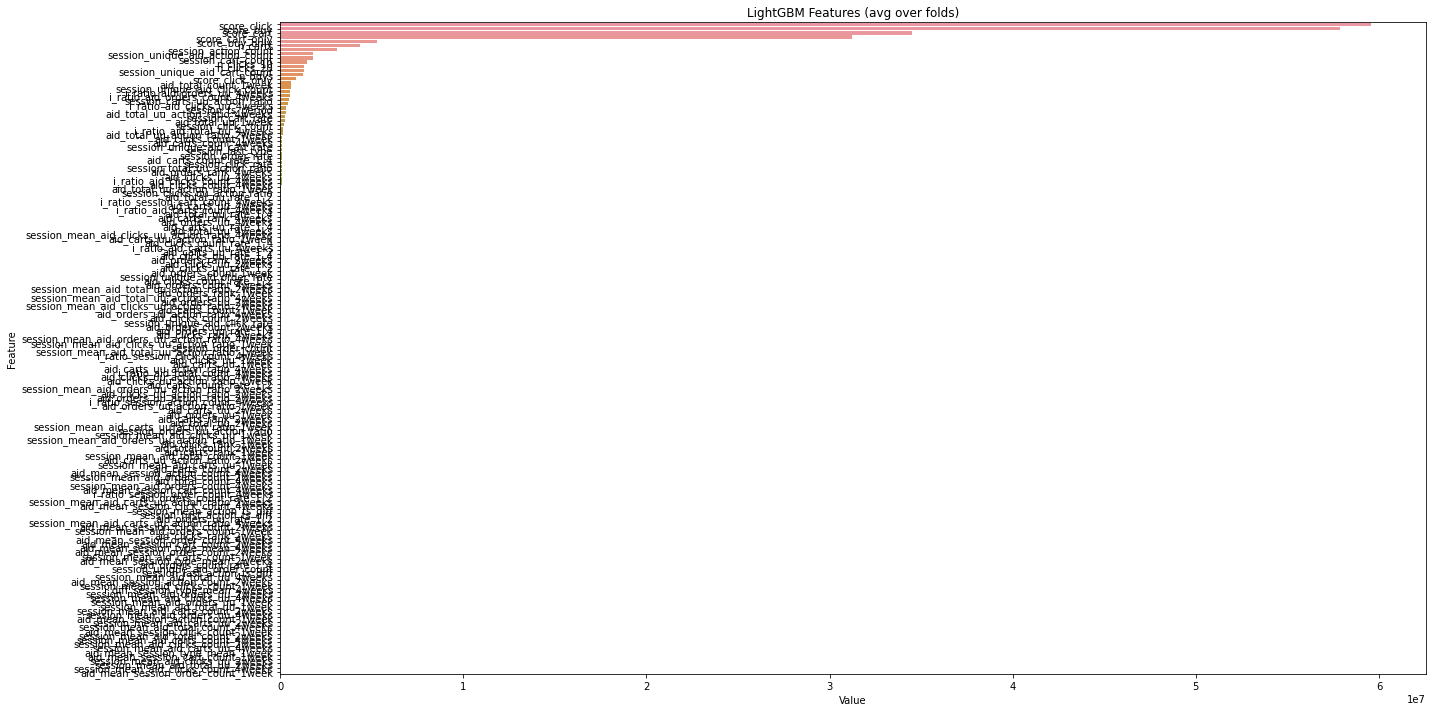

In [20]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)
model = np.load(f'{base_path}/otto/otto_lgbm_fold0_orders.pkl', allow_pickle=True)
#model = np.load(f'{base_path}/otto/backup/otto_lgbm_fold0_orders.pkl', allow_pickle=True)


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

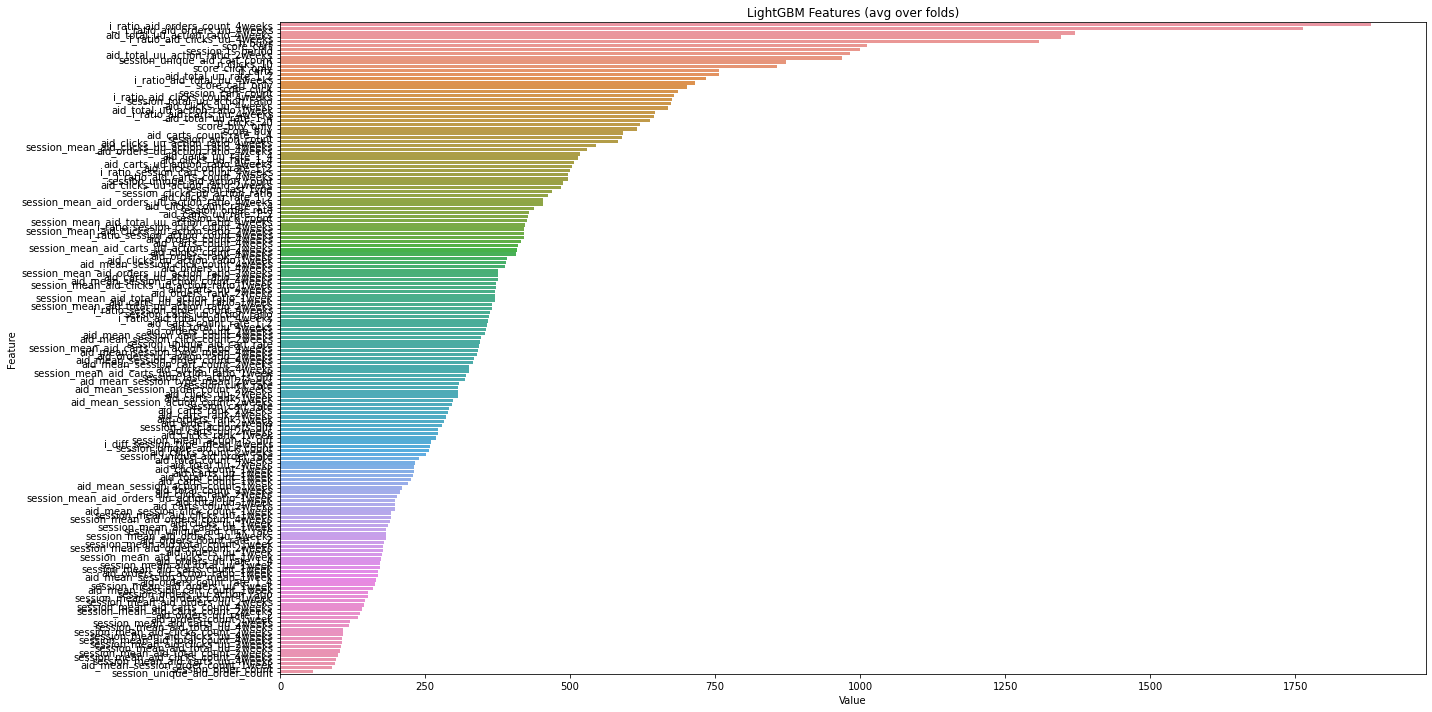

In [21]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [22]:
#ans_list = []
# 分割してpredictするための準備
Nrow = test.shape[0]
Ndiv = 10
n = int(Nrow // Ndiv) + 1
x_test = test.drop(IGNORE_COL , axis=1)
x_test_list = []
for i in range(Ndiv):
    tmp = x_test.iloc[i*n : (i+1)*n, :]
    x_test_list.append(tmp)
del x_test
gc.collect()

for target in type_list:
    print('target=', target,'*************')
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))

    # fold looop 
    for fold in range(n_splits):
        print('fold=', fold)
        model = np.load(f'{base_path}/otto/otto_lgbm_fold{fold}_{target}.pkl', allow_pickle=True)
        test_pred_list = [] 
        for i, v in enumerate(x_test_list):
            print('test pred i=', i)
            tmp = model.predict(v)
            test_pred_list.append(tmp) 

        test_pred = np.concatenate(test_pred_list)
        del test_pred_list, model
        gc.collect()

        # testの場合はfoldの数で割る
        test_predictions += test_pred / n_splits
    
    # dfに変換していったん保存
    test_predictions = pd.DataFrame(test_predictions, columns=["score"])
    #test_predictions.to_parquet(f'{base_path}/otto/test_predictions_{target}.parquet')
    test_predictions.to_csv(f'{base_path}/otto/test_oof_lgbm_{target}_{OUTPUT_SPLIT_NUM}.csv', index = False)
    del test_predictions
    gc.collect()

del x_test_list
gc.collect()

target= clicks *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
target= carts *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred 

0

## Load and Merge type

In [23]:
sub_df_list = []

# 今後はこの2つのcolumnsしか使わないので削っておく
test = test[['session', 'aid']]

for i, t in enumerate(type_list):
    print(i, t)
    #df = pd.read_parquet(f'{base_path}/otto/test_predictions_{t}.parquet')
    score = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_{t}_{OUTPUT_SPLIT_NUM}.csv')
    pred_df = pd.concat([test, score], axis=1)
    pred_df['aid'] = pred_df['aid'].astype('int32')
    del score
    gc.collect()
    for j in range(session_splits):
        print('splits session: ',j ,' from ' , session_splits_list[j])
        # last loop
        if j == session_splits - 1:
            tmp = pred_df[session_splits_list[j] <= pred_df['session']]
        else:
            tmp = pred_df[(session_splits_list[j] <= pred_df['session']) & (pred_df['session'] < session_splits_list[j+1])]
        tmp['session_type'] = tmp['session'].apply(lambda x: str(x) + f'_{t}')
        tmp = tmp.drop('session',axis=1)
        tmp = tmp.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)
        tmp['n'] = tmp.groupby('session_type').cumcount().astype('int16')
        tmp = tmp.loc[tmp.n<20].drop(['n','score'],axis=1)
        tmp = tmp.groupby('session_type')['aid'].apply(list).reset_index()
        tmp['labels'] = tmp['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
        tmp = tmp.drop(['aid'],axis=1)
        sub_df_list.append(tmp)

del tmp, test
gc.collect()

0 clicks
splits session:  0  from  13735680
splits session:  1  from  13902860
splits session:  2  from  14070040
splits session:  3  from  14237220
splits session:  4  from  14404400
1 carts
splits session:  0  from  13735680
splits session:  1  from  13902860
splits session:  2  from  14070040
splits session:  3  from  14237220
splits session:  4  from  14404400
2 orders
splits session:  0  from  13735680
splits session:  1  from  13902860
splits session:  2  from  14070040
splits session:  3  from  14237220
splits session:  4  from  14404400


0

In [24]:
#pred_df = pd.concat([sub_df_list[0], sub_df_list[1], sub_df_list[2]])
pred_df = pd.concat(sub_df_list)
del sub_df_list
gc.collect()

0

In [25]:
pred_df.to_csv(f"{base_path}/output/otto/test_preds_{OUTPUT_SPLIT_NUM}.csv", index=False)
pred_df.head()

,session_type,labels
0,13735680_clicks,761536 1055223 210106 1729638 15033 93867 1059...
1,13735681_clicks,1723650 1221547 1508939 1544699 1174980 880876...
2,13735682_clicks,573058 73864 141256 1628808 1084257 355441 569...
3,13735683_clicks,224347 666582 85484 293066 602580 1654653 1096...
4,13735684_clicks,451150 1184000 1158621 909320 255379 254951 41...


In [26]:
pred_df.shape

(2507706, 2)